## KPI: Cuántas órdenes se generan cada mes y cuál es su variación

In [2]:
import os

# Parte de donde sea que esté el CWD actualmente
d = os.getcwd()

# Subir hasta encontrar la carpeta "Entregable"
while os.path.basename(d) != "Entregable":
    parent = os.path.dirname(d)
    if parent == d:   # Llegó al disco sin encontrar Entregable
        raise RuntimeError("No se encontró la carpeta Entregable hacia arriba.")
    d = parent

os.chdir(d)
print("CWD fijado en:", os.getcwd())

CWD fijado en: c:\Users\Mariana\Dropbox\Cursos\SoyHenry\DataEngineering\Modulo02-ModeladoDeDatosYBDRelacionales\ProyectoIntegrador\Entregable


In [3]:
# Conexión a la base de datos
import pandas as pd
from sqlalchemy import text
from src.database.connection import DB

engine = DB.engine()

def q(sql):
    return pd.read_sql(text(sql), engine)

print("Conexión a la base de datos exitosa")

Conexión a la base de datos exitosa


In [4]:
from src.database.models import (
    Usuario, Producto, Categoria, Orden, DetalleOrden,
    DireccionEnvio, MetodoPago, OrdenMetodoPago,
    ResenaProducto, HistorialPago, Carrito
)
from sqlalchemy.orm import Session

session = Session(engine)

In [5]:
from sqlalchemy import create_engine, text
import pandas as pd

schema = "production"

query = text(f"""
    WITH resumen AS (
        SELECT
            EXTRACT(YEAR FROM fecha_orden)::int AS anio,
            EXTRACT(MONTH FROM fecha_orden)::int AS mes,
            COUNT(*) AS cantidad_ordenes
        FROM {schema}.ordenes
        WHERE fecha_orden > '2024-07-01'
        GROUP BY anio, mes
        ORDER BY anio, mes
    )
    SELECT
        anio,
        mes,
        cantidad_ordenes,
        ROUND(
            (cantidad_ordenes - LAG(cantidad_ordenes) OVER (ORDER BY anio, mes))::numeric
            / NULLIF(LAG(cantidad_ordenes) OVER (ORDER BY anio, mes), 0)
            * 100,
            2
        ) AS variacion_porcentual
    FROM resumen;
""")

df = pd.read_sql(query, engine)

print(df.head())


   anio  mes  cantidad_ordenes  variacion_porcentual
0  2024    7               828                   NaN
1  2024    8               864                  4.35
2  2024    9               806                 -6.71
3  2024   10               838                  3.97
4  2024   11               807                 -3.70


## Gráfica

In [6]:
# Crear una columna tipo fecha usando año y mes (día fijo 1)
df["fecha"] = pd.to_datetime(
    df["anio"].astype(str) + "-" + df["mes"].astype(str) + "-01"
)

# Ordenar por fecha por las dudas
df = df.sort_values("fecha")

### Cantidad de ventas

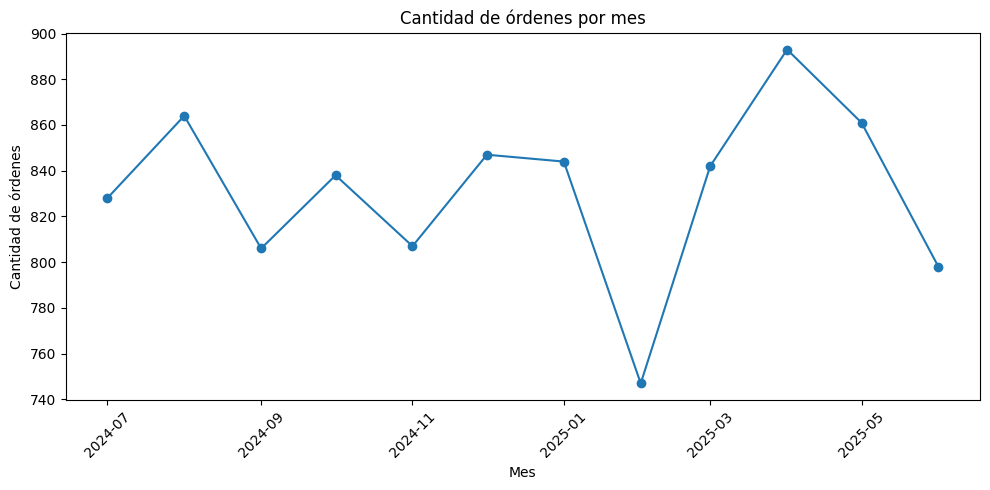

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(df["fecha"], df["cantidad_ordenes"], marker="o")
plt.title("Cantidad de órdenes por mes")
plt.xlabel("Mes")
plt.ylabel("Cantidad de órdenes")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Gráfico combinado cantidad y variación

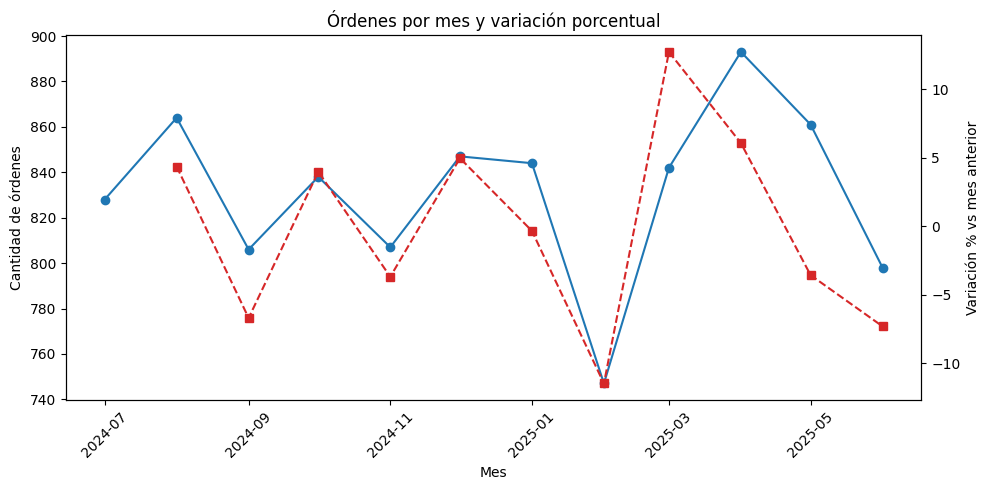

In [8]:
fig, ax1 = plt.subplots(figsize=(10, 5))

# Eje 1: cantidad de órdenes
ax1.plot(df["fecha"], df["cantidad_ordenes"], marker="o", color="tab:blue")
ax1.set_xlabel("Mes")
ax1.set_ylabel("Cantidad de órdenes")
ax1.tick_params(axis="x", rotation=45)

# Eje 2: variación porcentual
ax2 = ax1.twinx()
ax2.plot(df["fecha"], df["variacion_porcentual"], marker="s", linestyle="--", color="tab:red")
ax2.set_ylabel("Variación % vs mes anterior")

plt.title("Órdenes por mes y variación porcentual")
plt.tight_layout()
plt.show()


## Segundo KPI: Ticket promedio por orden por mes

In [9]:
query_ticket = text(f"""
    SELECT
        make_date(EXTRACT(YEAR FROM fecha_orden)::int,
                  EXTRACT(MONTH FROM fecha_orden)::int,
                  1) AS fecha,
        AVG(total) AS ticket_promedio
    FROM {schema}.ordenes
    GROUP BY fecha
    ORDER BY fecha;
""")

df_ticket = pd.read_sql(query_ticket, engine)
print(df_ticket.head())


        fecha  ticket_promedio
0  2024-06-01      1399.396000
1  2024-07-01      1129.107742
2  2024-08-01      1346.643183
3  2024-09-01      1203.058263
4  2024-10-01      1242.428604


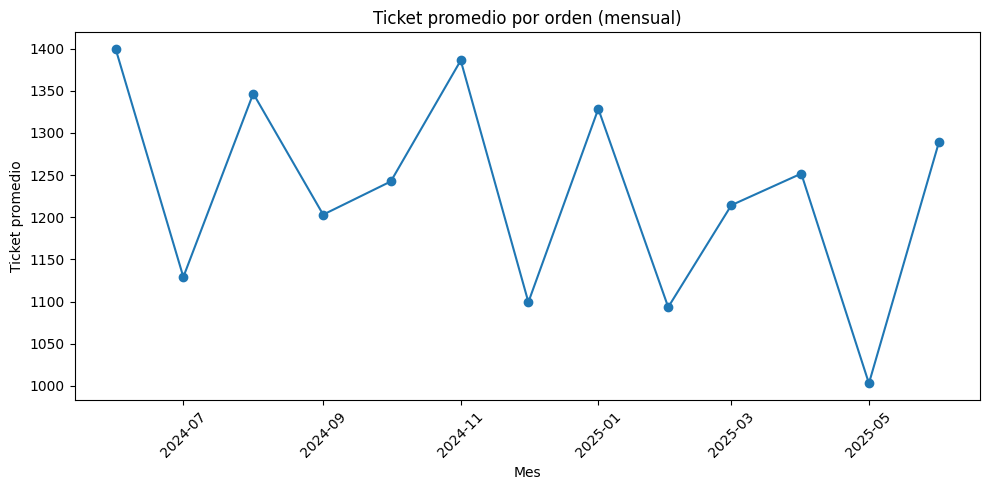

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(df_ticket["fecha"], df_ticket["ticket_promedio"], marker="o")
plt.title("Ticket promedio por orden (mensual)")
plt.xlabel("Mes")
plt.ylabel("Ticket promedio")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Tercer KPI: Monto total recaudado por mes

In [11]:
query_monto = text(f"""
    SELECT
        make_date(EXTRACT(YEAR FROM fecha_orden)::int,
                  EXTRACT(MONTH FROM fecha_orden)::int,
                  1) AS fecha,
        SUM(total) AS monto_total
    FROM {schema}.ordenes
    GROUP BY fecha
    ORDER BY fecha;
""")

df_monto = pd.read_sql(query_monto, engine)
print(df_monto.head())


        fecha  monto_total
0  2024-06-01     34984.90
1  2024-07-01    934901.21
2  2024-08-01   1163499.71
3  2024-09-01    969664.96
4  2024-10-01   1041155.17


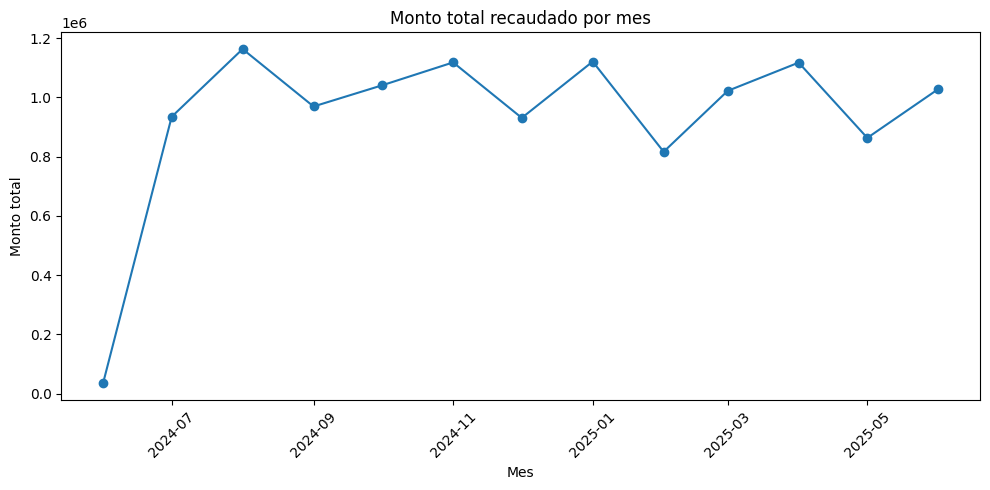

In [12]:
plt.figure(figsize=(10, 5))
plt.plot(df_monto["fecha"], df_monto["monto_total"], marker="o")
plt.title("Monto total recaudado por mes")
plt.xlabel("Mes")
plt.ylabel("Monto total")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
